Created 4 regions with 2 prototypes each
Generated 16 configurations
Creating atomic cells...
Created 40 atomic cells
Calculating membership degrees...
Creating visualization...


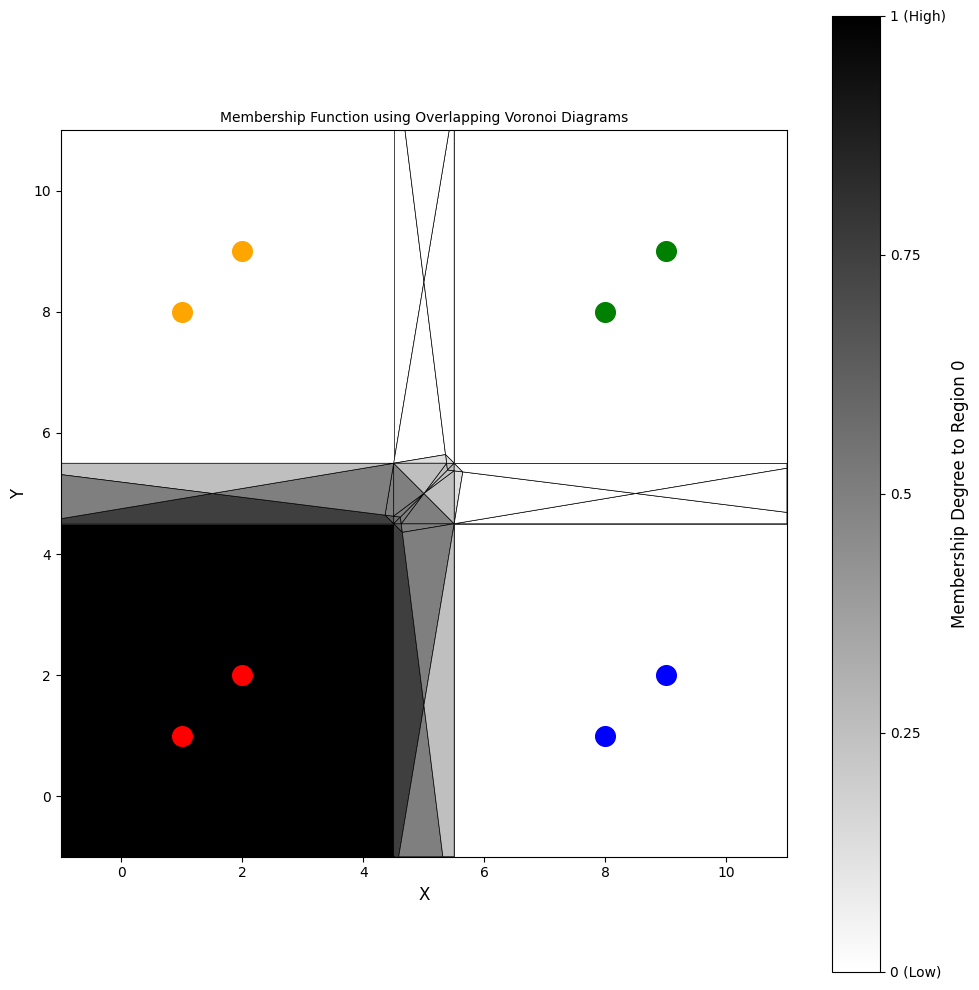


Unique membership degrees: [0.0, 0.125, 0.25, 0.5, 0.5625, 0.625, 0.75, 1.0]
Number of unique membership values: 8


In [ ]:
#@title Discrete membership function

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from shapely.geometry import Polygon, Point, box, LineString, MultiLineString
from shapely.ops import unary_union, polygonize
import itertools
from collections import defaultdict

# Step 1: Defining the Concept Space
def create_prototypes():
    """Create 4 regions, each with 2 prototype points"""
    prototypes = [
        # Region r_0 (bottom-left)
        [np.array([1.0, 1.0]), np.array([2.0, 2.0])],
        # Region r_1 (bottom-right)
        [np.array([8.0, 1.0]), np.array([9.0, 2.0])],
        # Region r_2 (top-right)
        [np.array([8.0, 8.0]), np.array([9.0, 9.0])],
        # Region r_3 (top-left)
        [np.array([1.0, 8.0]), np.array([2.0, 9.0])]
    ]
    return prototypes

# Step 2: Generating Configurations
def generate_configurations(prototypes):
    """Generate all possible prototype configurations"""
    configurations = list(itertools.product(*prototypes))
    return configurations

# Step 3: Constructing Individual Voronoi Diagrams
def voronoi_finite_polygons_2d(vor, radius=None):
    """Convert infinite Voronoi regions to finite polygons"""
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max() * 2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # Finite region
            new_regions.append(vertices)
            continue

        # Reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                continue

            # Compute the missing endpoint of an infinite ridge
            t = vor.points[p2] - vor.points[p1]
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # Sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

# Step 4: Constructing the Collated Voronoi Diagram
def create_atomic_cells(configurations, prototypes, bbox):
    """Create atomic cells by overlaying all Voronoi diagrams"""
    # Collect all edges from all Voronoi diagrams
    all_lines = []

    for config in configurations:
        points = np.array(config)
        vor = Voronoi(points)

        # Extract finite edges
        for simplex in vor.ridge_vertices:
            if all(i >= 0 for i in simplex):
                i, j = simplex
                p1 = vor.vertices[i]
                p2 = vor.vertices[j]
                # Create LineString instead of Polygon boundary
                line = LineString([p1, p2])
                # Clip to bbox
                clipped = line.intersection(bbox)
                if not clipped.is_empty:
                    all_lines.append(clipped)

        # Handle infinite edges
        center = vor.points.mean(axis=0)
        for pointidx, simplex in zip(vor.ridge_points, vor.ridge_vertices):
            simplex = np.asarray(simplex)
            if np.any(simplex < 0):
                i = simplex[simplex >= 0][0]  # finite end Voronoi vertex

                t = vor.points[pointidx[1]] - vor.points[pointidx[0]]  # tangent
                t /= np.linalg.norm(t)
                n = np.array([-t[1], t[0]])  # normal

                midpoint = vor.points[pointidx].mean(axis=0)
                direction = np.sign(np.dot(midpoint - center, n)) * n

                # Extend the edge to bbox boundary
                far_point = vor.vertices[i] + direction * 20
                line = LineString([vor.vertices[i], far_point])
                clipped = line.intersection(bbox)
                if not clipped.is_empty and hasattr(clipped, 'coords'):
                    all_lines.append(clipped)

    # Add bbox edges as separate line segments
    coords = list(bbox.exterior.coords)
    for i in range(len(coords) - 1):
        all_lines.append(LineString([coords[i], coords[i + 1]]))

    # Create union of all lines and polygonize
    if all_lines:
        merged = unary_union(all_lines)
        # Ensure we have a collection of lines
        if hasattr(merged, 'geoms'):
            atomic_polygons = list(polygonize(merged))
        else:
            atomic_polygons = list(polygonize([merged]))
    else:
        atomic_polygons = [bbox]

    # Filter out invalid or empty polygons
    valid_polygons = []
    for poly in atomic_polygons:
        if poly.is_valid and not poly.is_empty and poly.area > 1e-10:
            valid_polygons.append(poly)

    return valid_polygons

# Step 5: Calculate Membership Degrees
def calculate_membership_degrees(atomic_cells, configurations, prototypes, target_region=0):
    """Calculate membership degree for each atomic cell"""
    membership_degrees = {}

    for cell_idx, cell in enumerate(atomic_cells):
        # Get representative point
        representative = cell.centroid
        if not cell.contains(representative):
            representative = cell.representative_point()

        # Count configurations where representative belongs to target region
        count = 0
        for config_idx, config in enumerate(configurations):
            # Find which prototype in this configuration is closest
            points = np.array(config)
            distances = np.linalg.norm(points - np.array([representative.x, representative.y]), axis=1)
            closest_idx = np.argmin(distances)

            # Check which region this prototype belongs to
            # In our setup, config is ordered by regions, so:
            # index 0 -> region 0, index 1 -> region 1, etc.
            prototype_region = closest_idx

            if prototype_region == target_region:
                count += 1

        membership_degree = count / len(configurations)
        membership_degrees[cell_idx] = membership_degree

    return membership_degrees

# Step 6: Visualization
def visualize_membership_function(atomic_cells, membership_degrees, prototypes):
    """Visualize the membership function"""
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))

    # Create grayscale colormap (reversed so high values are dark)
    cmap = plt.cm.gray_r  # reversed gray: 0=white, 1=black
    norm = plt.Normalize(vmin=0, vmax=1)

    # Plot atomic cells
    for cell_idx, cell in enumerate(atomic_cells):
        if cell_idx in membership_degrees:
            # Convert membership degree to grayscale
            gray_value = membership_degrees[cell_idx]
            color = cmap(norm(gray_value))

            if hasattr(cell, 'exterior'):
                x, y = cell.exterior.xy
                ax.fill(x, y, color=color, edgecolor='black', linewidth=0.5, alpha=1.0)

    # Plot prototype points
    colors = ['red', 'blue', 'green', 'orange']

    for i, region_prototypes in enumerate(prototypes):
        for j, proto in enumerate(region_prototypes):
            # Use circles for both prototypes, differentiate by fill
            if j == 0:
                # First prototype: filled circle
                ax.scatter(proto[0], proto[1],
                          color=colors[i], s=200,
                          marker='o',
                          label=f'Region {i}',
                          zorder=5)
            else:
                # Second prototype: circle with white fill
                ax.scatter(proto[0], proto[1],
                          color=colors[i], s=200,
                          marker='o',
                          label=f'Region {i}',
                          zorder=5)

    # Add colorbar with grayscale
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Membership Degree to Region 0', fontsize=12)

    # Add custom tick labels to clarify the scale
    cbar.set_ticks([0, 0.25, 0.5, 0.75, 1.0])
    cbar.set_ticklabels(['0 (Low)', '0.25', '0.5', '0.75', '1 (High)'])

    # Set plot properties
    ax.set_xlim(-1, 11)
    ax.set_ylim(-1, 11)
    ax.set_aspect('equal')
    ax.set_xlabel('X', fontsize=12)
    ax.set_ylabel('Y', fontsize=12)
    ax.set_title('Membership Function using Overlapping Voronoi Diagrams', fontsize=10)

    plt.tight_layout()
    plt.show()

# Main execution
def main():
    # Step 1: Create prototypes
    prototypes = create_prototypes()
    print(f"Created {len(prototypes)} regions with 2 prototypes each")

    # Step 2: Generate configurations
    configurations = generate_configurations(prototypes)
    print(f"Generated {len(configurations)} configurations")

    # Define bounding box
    bbox = box(-1, -1, 11, 11)

    # Step 4: Create atomic cells
    print("Creating atomic cells...")
    atomic_cells = create_atomic_cells(configurations, prototypes, bbox)
    print(f"Created {len(atomic_cells)} atomic cells")

    # Step 5: Calculate membership degrees
    print("Calculating membership degrees...")
    target_region = 0  # Choose region r_0 as target
    membership_degrees = calculate_membership_degrees(atomic_cells, configurations, prototypes, target_region)

    # Step 6: Visualize
    print("Creating visualization...")
    visualize_membership_function(atomic_cells, membership_degrees, prototypes)

    # Print statistics
    unique_degrees = sorted(set(membership_degrees.values()))
    print(f"\nUnique membership degrees: {unique_degrees}")
    print(f"Number of unique membership values: {len(unique_degrees)}")

if __name__ == "__main__":
    main()

Starting visualization...
Creating reference grid...
Calculating conceptual core...
Calculating continuous membership function...
Progress: 20.0%
Progress: 40.0%
Progress: 60.0%
Progress: 80.0%
Progress: 100.0%


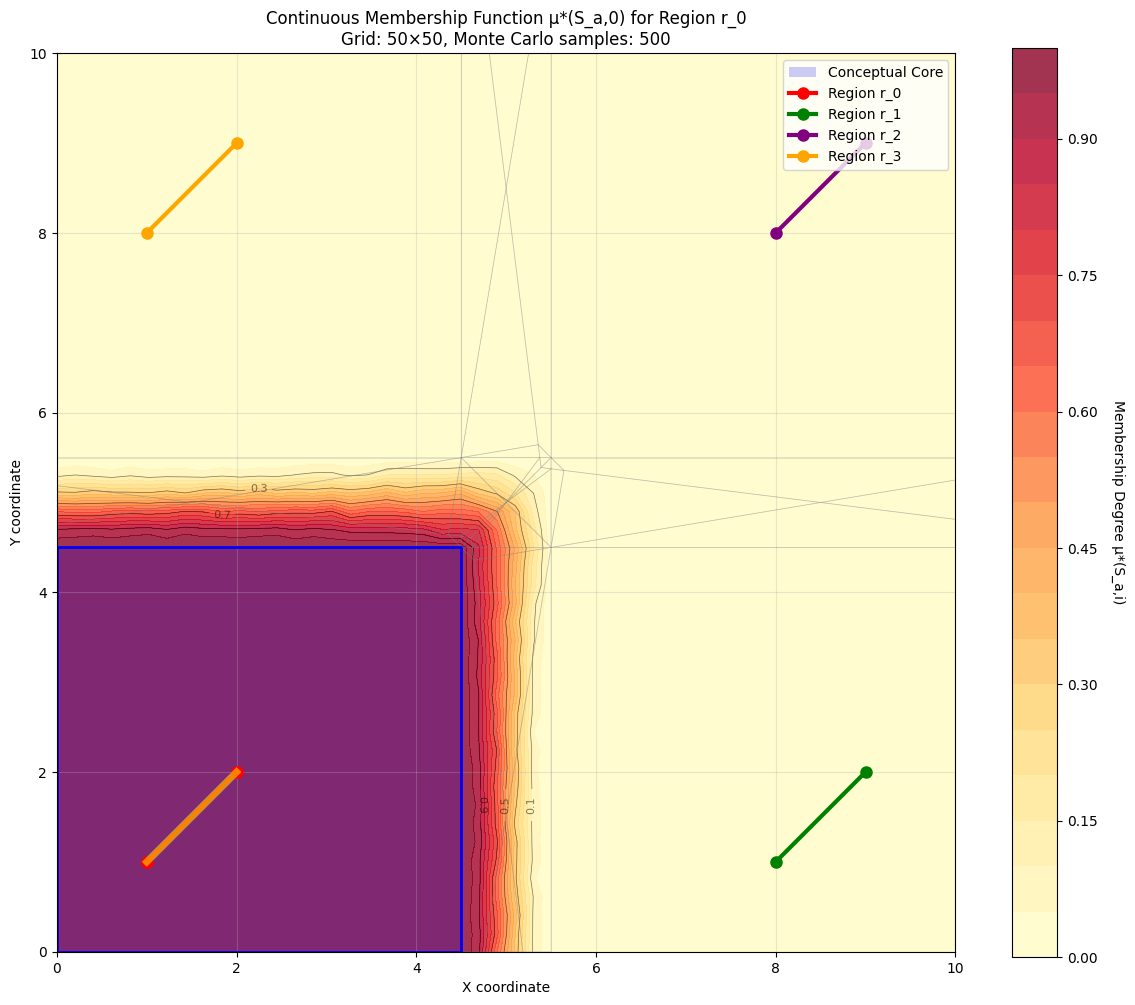

In [ ]:
#@title Continuous membership function

import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from shapely.geometry import Polygon, Point, box, LineString, MultiLineString
from shapely.ops import unary_union, polygonize
import itertools
from collections import defaultdict
from matplotlib.patches import Polygon as MPLPolygon
from matplotlib.collections import PatchCollection
import matplotlib.cm as cm

# Step 1: Define the endpoints of continuous prototypical regions
def define_prototype_segment_endpoints():
    """
    Defines the endpoint points for the 4 continuous prototypical regions (segments).
    """
    prototypes = [
        # Region r_0 (bottom left)
        [np.array([1.0, 1.0]), np.array([2.0, 2.0])],
        # Region r_1 (bottom right)
        [np.array([8.0, 1.0]), np.array([9.0, 2.0])],
        # Region r_2 (top right)
        [np.array([8.0, 8.0]), np.array([9.0, 9.0])],
        # Region r_3 (top left)
        [np.array([1.0, 8.0]), np.array([2.0, 9.0])]
    ]
    return prototypes

# Step 2: Generate discrete configurations for visualization
def generate_discrete_configurations_for_reference(prototype_endpoints):
    """
    Generates the 16 discrete prototype configurations using the segment endpoints.
    """
    configurations = list(itertools.product(*prototype_endpoints))
    return configurations

# Step 3: Utility for handling infinite Voronoi polygons (FIXED for NumPy 2.0)
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Converts infinite Voronoi regions from Scipy into finite polygons.
    """
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        # Fixed for NumPy 2.0: use np.ptp instead of .ptp()
        radius = np.ptp(vor.points, axis=0).max() * 2

    # Construct a map of ridge points to indices
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Process each point's region
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all(v >= 0 for v in vertices):
            # Finite region
            new_regions.append(vertices)
            continue

        # Reconstruct infinite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                continue

            # Compute the direction of the infinite ridge
            t = vor.points[p2] - vor.points[p1]
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # Normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # Sort vertices by angle
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:, 1] - c[1], vs[:, 0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

# Step 4: Build the visual background grid (Type 2 Polygons)
def create_visual_reference_grid(configurations, bbox):
    """
    Creates 'Type 2' polygons by overlaying the 16 discrete Voronoi diagrams.
    """
    all_lines = []

    for config in configurations:
        points = np.array(config)
        vor = Voronoi(points)
        center = vor.points.mean(axis=0)

        for pointidx, simplex in zip(vor.ridge_points, vor.ridge_vertices):
            simplex = np.asarray(simplex)
            if np.all(simplex >= 0):
                line = LineString([vor.vertices[i] for i in simplex])
                all_lines.append(line.intersection(bbox))
            else:
                i = simplex[simplex >= 0][0]
                t = vor.points[pointidx[1]] - vor.points[pointidx[0]]
                t /= np.linalg.norm(t)
                n = np.array([-t[1], t[0]])
                midpoint = vor.points[pointidx].mean(axis=0)
                direction = np.sign(np.dot(midpoint - center, n)) * n
                far_point = vor.vertices[i] + direction * 20
                line = LineString([vor.vertices[i], far_point])
                all_lines.append(line.intersection(bbox))

    merged_lines = unary_union([line for line in all_lines if not line.is_empty])
    border = box(*bbox.bounds).boundary
    all_boundaries = unary_union([merged_lines, border])

    atomic_polygons = list(polygonize(all_boundaries))

    return [poly for poly in atomic_polygons if poly.is_valid and poly.area > 1e-9]

# Step 5: Calculate the Conceptual Core
def calculate_conceptual_core(configurations, target_region_idx, bbox):
    """
    Calculates the conceptual core K_i where discrete membership is 1.
    """
    relevant_polygons = []

    for config in configurations:
        points = np.array(config)
        vor = Voronoi(points)

        # Get finite polygons
        regions, vertices = voronoi_finite_polygons_2d(vor)

        # Find the polygon for the target region
        target_polygon = Polygon(vertices[regions[target_region_idx]])

        # Clip to bounding box
        clipped_polygon = target_polygon.intersection(bbox)
        if clipped_polygon.is_valid and not clipped_polygon.is_empty:
            relevant_polygons.append(clipped_polygon)

    # Calculate intersection of all relevant polygons
    if relevant_polygons:
        conceptual_core = relevant_polygons[0]
        for poly in relevant_polygons[1:]:
            conceptual_core = conceptual_core.intersection(poly)
        return conceptual_core if conceptual_core.is_valid else None
    return None

# Step 6: Monte Carlo calculation of continuous membership function
def calculate_continuous_membership_monte_carlo(point, prototype_segments, target_idx, n_samples=1000):
    """
    Calculates μ*(S_a,i) for a single point using Monte Carlo integration.
    """
    favorable_count = 0

    for _ in range(n_samples):
        # Generate random configuration
        config = []
        for segment in prototype_segments:
            # Random point on segment: p = p1 + t * (p2 - p1), t ∈ [0,1]
            t = np.random.random()
            p = segment[0] + t * (segment[1] - segment[0])
            config.append(p)

        # Calculate distances from point to all prototypes
        distances = [np.linalg.norm(point - p) for p in config]

        # Check if target prototype is closest
        if np.argmin(distances) == target_idx:
            favorable_count += 1

    return favorable_count / n_samples

# Step 7: Calculate membership function over entire grid
def calculate_membership_grid(prototype_segments, target_idx, grid_size=100, n_samples=1000, bounds=None):
    """
    Calculates the continuous membership function over a 2D grid.
    """
    if bounds is None:
        # Calculate bounds from prototype segments
        all_points = np.vstack([np.vstack(seg) for seg in prototype_segments])
        min_coords = all_points.min(axis=0) - 2
        max_coords = all_points.max(axis=0) + 2
        bounds = [min_coords[0], max_coords[0], min_coords[1], max_coords[1]]

    x = np.linspace(bounds[0], bounds[1], grid_size)
    y = np.linspace(bounds[2], bounds[3], grid_size)
    X, Y = np.meshgrid(x, y)

    # Initialize membership values
    membership = np.zeros((grid_size, grid_size))

    # Calculate membership for each grid point
    for i in range(grid_size):
        for j in range(grid_size):
            point = np.array([X[i, j], Y[i, j]])
            membership[i, j] = calculate_continuous_membership_monte_carlo(
                point, prototype_segments, target_idx, n_samples
            )

        # Progress indicator
        if (i + 1) % 10 == 0:
            print(f"Progress: {(i + 1) / grid_size * 100:.1f}%")

    return X, Y, membership

# Step 8: Main visualization function
def visualize_continuous_membership(prototype_segments, target_idx=0, grid_size=100, n_samples=1000):
    """
    Creates a comprehensive visualization of the continuous membership function.
    """
    # Set up the figure
    fig, ax = plt.subplots(1, 1, figsize=(12, 10))

    # Define bounds
    all_points = np.vstack([np.vstack(seg) for seg in prototype_segments])
    min_coords = all_points.min(axis=0) - 1
    max_coords = all_points.max(axis=0) + 1
    bounds = [min_coords[0], max_coords[0], min_coords[1], max_coords[1]]
    bbox = box(bounds[0], bounds[2], bounds[1], bounds[3])

    # Generate discrete configurations for reference
    configurations = generate_discrete_configurations_for_reference(prototype_segments)

    # Create visual reference grid (Type 2 polygons)
    print("Creating reference grid...")
    atomic_polygons = create_visual_reference_grid(configurations, bbox)

    # Calculate conceptual core
    print("Calculating conceptual core...")
    conceptual_core = calculate_conceptual_core(configurations, target_idx, bbox)

    # Calculate continuous membership function
    print("Calculating continuous membership function...")
    X, Y, membership = calculate_membership_grid(
        prototype_segments, target_idx, grid_size, n_samples, bounds
    )

    # Plot continuous membership function as heatmap
    im = ax.contourf(X, Y, membership, levels=20, cmap='YlOrRd', alpha=0.8)

    # Add contour lines
    contours = ax.contour(X, Y, membership, levels=[0.1, 0.3, 0.5, 0.7, 0.9],
                         colors='black', linewidths=0.5, alpha=0.5)
    ax.clabel(contours, inline=True, fontsize=8)

    # Draw Type 2 polygon boundaries
    for poly in atomic_polygons:
        x, y = poly.exterior.xy
        ax.plot(x, y, 'gray', linewidth=0.5, alpha=0.3)

    # Draw conceptual core
    if conceptual_core and not conceptual_core.is_empty:
        if conceptual_core.geom_type == 'Polygon':
            x, y = conceptual_core.exterior.xy
            ax.fill(x, y, 'blue', alpha=0.2, label='Conceptual Core')
            ax.plot(x, y, 'blue', linewidth=2)
        elif conceptual_core.geom_type == 'MultiPolygon':
            for poly in conceptual_core.geoms:
                x, y = poly.exterior.xy
                ax.fill(x, y, 'blue', alpha=0.2)
                ax.plot(x, y, 'blue', linewidth=2)

    # Draw prototype segments
    colors = ['red', 'green', 'purple', 'orange']
    for i, segment in enumerate(prototype_segments):
        p1, p2 = segment
        ax.plot([p1[0], p2[0]], [p1[1], p2[1]], colors[i], linewidth=3,
                label=f'Region r_{i}', marker='o', markersize=8)

        # Highlight target region
        if i == target_idx:
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 'yellow', linewidth=5,
                   alpha=0.5, zorder=10)

    # Colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Membership Degree μ*(S_a,i)', rotation=270, labelpad=20)

    # Labels and title
    ax.set_xlabel('X coordinate')
    ax.set_ylabel('Y coordinate')
    ax.set_title(f'Continuous Membership Function μ*(S_a,{target_idx}) for Region r_{target_idx}\n' +
                f'Grid: {grid_size}×{grid_size}, Monte Carlo samples: {n_samples}')
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.set_aspect('equal')

    plt.tight_layout()
    return fig, ax

# Alternative: Faster vectorized Monte Carlo implementation
def calculate_membership_grid_vectorized(prototype_segments, target_idx, grid_size=100, n_samples=1000, bounds=None):
    """
    Faster vectorized version of the membership calculation.
    """
    if bounds is None:
        all_points = np.vstack([np.vstack(seg) for seg in prototype_segments])
        min_coords = all_points.min(axis=0) - 2
        max_coords = all_points.max(axis=0) + 2
        bounds = [min_coords[0], max_coords[0], min_coords[1], max_coords[1]]

    x = np.linspace(bounds[0], bounds[1], grid_size)
    y = np.linspace(bounds[2], bounds[3], grid_size)
    X, Y = np.meshgrid(x, y)

    # Flatten grid for vectorized computation
    points = np.column_stack([X.ravel(), Y.ravel()])
    n_points = points.shape[0]

    # Pre-generate all random configurations
    print("Generating random configurations...")
    favorable_counts = np.zeros(n_points)

    batch_size = 100  # Process in batches to manage memory
    n_batches = (n_samples + batch_size - 1) // batch_size

    for batch_idx in range(n_batches):
        current_batch_size = min(batch_size, n_samples - batch_idx * batch_size)

        # Generate random configurations for this batch
        configs = []
        for segment in prototype_segments:
            t = np.random.random(current_batch_size)
            p = segment[0][np.newaxis, :] + t[:, np.newaxis] * (segment[1] - segment[0])[np.newaxis, :]
            configs.append(p)

        # Calculate distances for all points and configurations
        for sample_idx in range(current_batch_size):
            config = [configs[i][sample_idx] for i in range(len(prototype_segments))]

            # Vectorized distance calculation
            distances = np.array([np.linalg.norm(points - p[np.newaxis, :], axis=1) for p in config]).T

            # Check which points have target as closest
            closest = np.argmin(distances, axis=1)
            favorable_counts += (closest == target_idx)

        # Progress indicator
        if (batch_idx + 1) % 10 == 0:
            progress = (batch_idx + 1) / n_batches * 100
            print(f"Monte Carlo progress: {progress:.1f}%")

    # Reshape results
    membership = (favorable_counts / n_samples).reshape(grid_size, grid_size)

    return X, Y, membership

# Main execution
if __name__ == "__main__":
    # Define prototype segments
    prototype_segments = define_prototype_segment_endpoints()

    # Choose target region (0-3)
    target_region = 0

    # Create visualization
    print("Starting visualization...")
    fig, ax = visualize_continuous_membership(
        prototype_segments,
        target_idx=target_region,
        grid_size=50,  # Reduced for faster computation
        n_samples=500   # Reduced for faster computation
    )

    plt.show()

Creating reference grid...
Calculating conceptual core...
Calculating continuous membership...


Computing Membership: 100%|██████████| 50/50 [00:49<00:00,  1.01it/s]


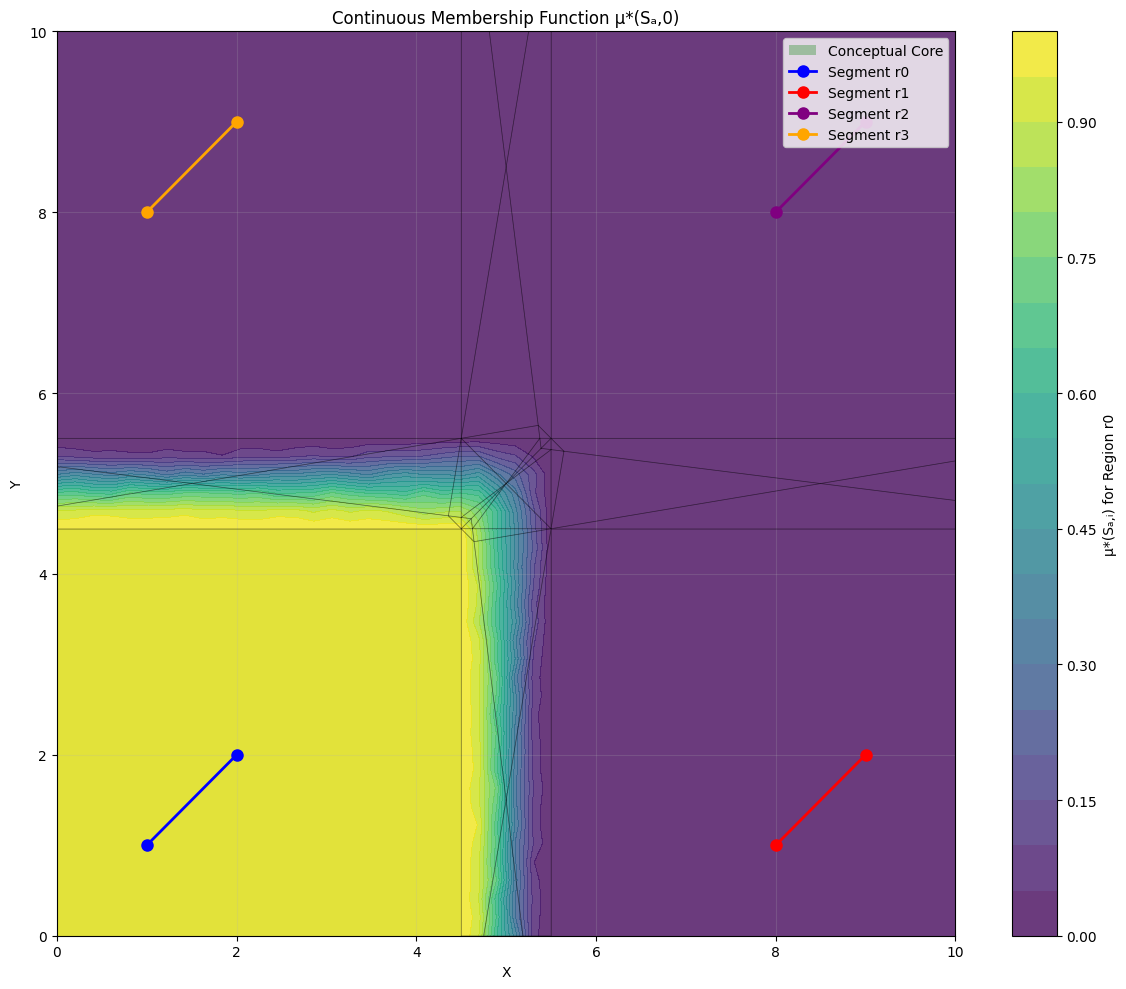

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi
from shapely.geometry import Polygon, Point, box, LineString, MultiLineString
from shapely.ops import unary_union, polygonize
import itertools
from tqdm import tqdm  # For progress bar
from collections import defaultdict

# Set random seed for reproducibility
np.random.seed(42)

# Step 1: Define prototype segment endpoints
def define_prototype_segments():
    return [
        [np.array([1.0, 1.0]), np.array([2.0, 2.0])],  # Region r0
        [np.array([8.0, 1.0]), np.array([9.0, 2.0])],  # Region r1
        [np.array([8.0, 8.0]), np.array([9.0, 9.0])],  # Region r2
        [np.array([1.0, 8.0]), np.array([2.0, 9.0])]   # Region r3
    ]

# Step 2: Generate discrete configurations
def generate_discrete_configurations(prototype_endpoints):
    return list(itertools.product(*prototype_endpoints))

# Step 3: Clip infinite Voronoi regions
def voronoi_finite_polygons_2d(vor, radius=None):
    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions, new_vertices = [], vor.vertices.tolist()
    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max() * 2

    all_ridges = defaultdict(list)
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges[p1].append((p2, v1, v2))
        all_ridges[p2].append((p1, v1, v2))

    for p1, region_idx in enumerate(vor.point_region):
        vertices = vor.regions[region_idx]
        if all(v >= 0 for v in vertices):
            new_regions.append(vertices)
            continue

        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                continue

            t = vor.points[p2] - vor.points[p1]
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])
            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius
            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

# Step 4: Create reference grid (Type 2 polygons)
def create_reference_grid(configurations, bbox):
    all_lines = []
    for config in configurations:
        points = np.array(config)
        vor = Voronoi(points)
        regions, vertices = voronoi_finite_polygons_2d(vor, radius=15)

        for region in regions:
            poly_vertices = vertices[region]
            poly = Polygon(poly_vertices)
            if not poly.is_valid:
                poly = poly.buffer(0)
            boundary = poly.boundary
            if isinstance(boundary, LineString):
                all_lines.append(boundary.intersection(bbox))
            elif isinstance(boundary, MultiLineString):
                for line in boundary.geoms:
                    all_lines.append(line.intersection(bbox))

    merged_lines = unary_union([line for line in all_lines if not line.is_empty])
    border_lines = bbox.boundary
    union_lines = unary_union([merged_lines, border_lines])
    atomic_polygons = list(polygonize(union_lines))
    return [poly for poly in atomic_polygons if poly.is_valid and poly.area > 1e-9]

# Step 5: Calculate conceptual core K_i
def calculate_conceptual_core(configurations, target_idx, bbox):
    core_poly = None
    for config in configurations:
        points = np.array(config)
        vor = Voronoi(points)
        regions, vertices = voronoi_finite_polygons_2d(vor, radius=15)
        region_poly = Polygon(vertices[regions[target_idx]])

        if not region_poly.is_valid:
            region_poly = region_poly.buffer(0)
        region_poly = region_poly.intersection(bbox)

        if core_poly is None:
            core_poly = region_poly
        else:
            core_poly = core_poly.intersection(region_poly)

    return core_poly

# Step 6: Monte Carlo membership calculation
def calculate_membership(prototype_segments, target_idx, grid_x, grid_y, N=1000):
    membership = np.zeros((len(grid_y), len(grid_x)))
    segments = [np.array(seg) for seg in prototype_segments]

    for i, y in tqdm(enumerate(grid_y), total=len(grid_y), desc="Computing Membership"):
        for j, x in enumerate(grid_x):
            a = np.array([x, y])
            favorable = 0

            for _ in range(N):
                # Generate random configuration
                config = []
                for seg in segments:
                    t = np.random.rand()
                    point = seg[0] + t * (seg[1] - seg[0])
                    config.append(point)

                config = np.array(config)
                dists = np.linalg.norm(config - a, axis=1)

                if np.argmin(dists) == target_idx:
                    favorable += 1

            membership[i, j] = favorable / N

    return membership

# Main execution
if __name__ == "__main__":
    # Configuration
    TARGET_IDX = 0  # Target region index (r0)
    N_MC = 500      # Monte Carlo samples per point
    GRID_RES = 50   # Grid resolution (points per dimension)

    # Define prototype segments
    prototype_segments = define_prototype_segments()

    # Create bounding box
    all_points = np.vstack([np.array(seg) for seg in prototype_segments])
    x_min, y_min = np.min(all_points, axis=0) - 1
    x_max, y_max = np.max(all_points, axis=0) + 1
    bbox = box(x_min, y_min, x_max, y_max)

    # Generate discrete configurations
    discrete_configs = generate_discrete_configurations(prototype_segments)

    # Create reference grid (Type 2 polygons)
    print("Creating reference grid...")
    atomic_polygons = create_reference_grid(discrete_configs, bbox)

    # Calculate conceptual core
    print("Calculating conceptual core...")
    conceptual_core = calculate_conceptual_core(discrete_configs, TARGET_IDX, bbox)

    # Create evaluation grid
    grid_x = np.linspace(x_min, x_max, GRID_RES)
    grid_y = np.linspace(y_min, y_max, GRID_RES)
    X, Y = np.meshgrid(grid_x, grid_y)

    # Calculate membership function
    print("Calculating continuous membership...")
    membership = calculate_membership(prototype_segments, TARGET_IDX, grid_x, grid_y, N_MC)

    # Visualization
    plt.figure(figsize=(12, 10))

    # Plot atomic polygons (reference grid)
    for poly in atomic_polygons:
        x, y = poly.exterior.xy
        plt.plot(x, y, 'k-', linewidth=0.5, alpha=0.3)

    # Plot conceptual core
    if conceptual_core.geom_type == 'Polygon':
        x, y = conceptual_core.exterior.xy
        plt.fill(x, y, 'green', alpha=0.3, label='Conceptual Core')
    elif conceptual_core.geom_type == 'MultiPolygon':
        for poly in conceptual_core.geoms:
            x, y = poly.exterior.xy
            plt.fill(x, y, 'green', alpha=0.3)

    # Plot membership function
    contour = plt.contourf(X, Y, membership, levels=20, cmap='viridis', alpha=0.8)
    plt.colorbar(contour, label=f'μ*(Sₐ,ᵢ) for Region r{TARGET_IDX}')

    # Plot prototype segments
    colors = ['blue', 'red', 'purple', 'orange']
    for i, seg in enumerate(prototype_segments):
        plt.plot([seg[0][0], seg[1][0]], [seg[0][1], seg[1][1]],
                 'o-', color=colors[i], linewidth=2, markersize=8,
                 label=f'Segment r{i}')

    plt.title(f'Continuous Membership Function μ*(Sₐ,{TARGET_IDX})')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend(loc='upper right')
    plt.grid(alpha=0.2)
    plt.tight_layout()
    plt.show()

In [ ]:
import random

def random_triangle(center_x, center_y, spread=0.3):
    return [
        (round(center_x + random.uniform(-spread, spread), 8), round(center_y + random.uniform(-spread, spread), 8)),
        (round(center_x + random.uniform(-spread, spread), 8), round(center_y + random.uniform(-spread, spread), 8)),
        (round(center_x + random.uniform(-spread, spread), 8), round(center_y + random.uniform(-spread, spread), 8)),
    ]

# Choose centers far apart
centers = [
    (random.uniform(0, 1), random.uniform(0, 1)),
    (random.uniform(3, 4), random.uniform(0, 1)),
    (random.uniform(1, 2), random.uniform(3, 4)),
]

vertices = {
    f'r{i+1}': random_triangle(cx, cy)
    for i, (cx, cy) in enumerate(centers)
}

Generated 81 discrete configurations
Conceptual core computed: True
Computing membership values via Monte Carlo...
Progress: 0/50
Progress: 10/50
Progress: 20/50
Progress: 30/50
Progress: 40/50


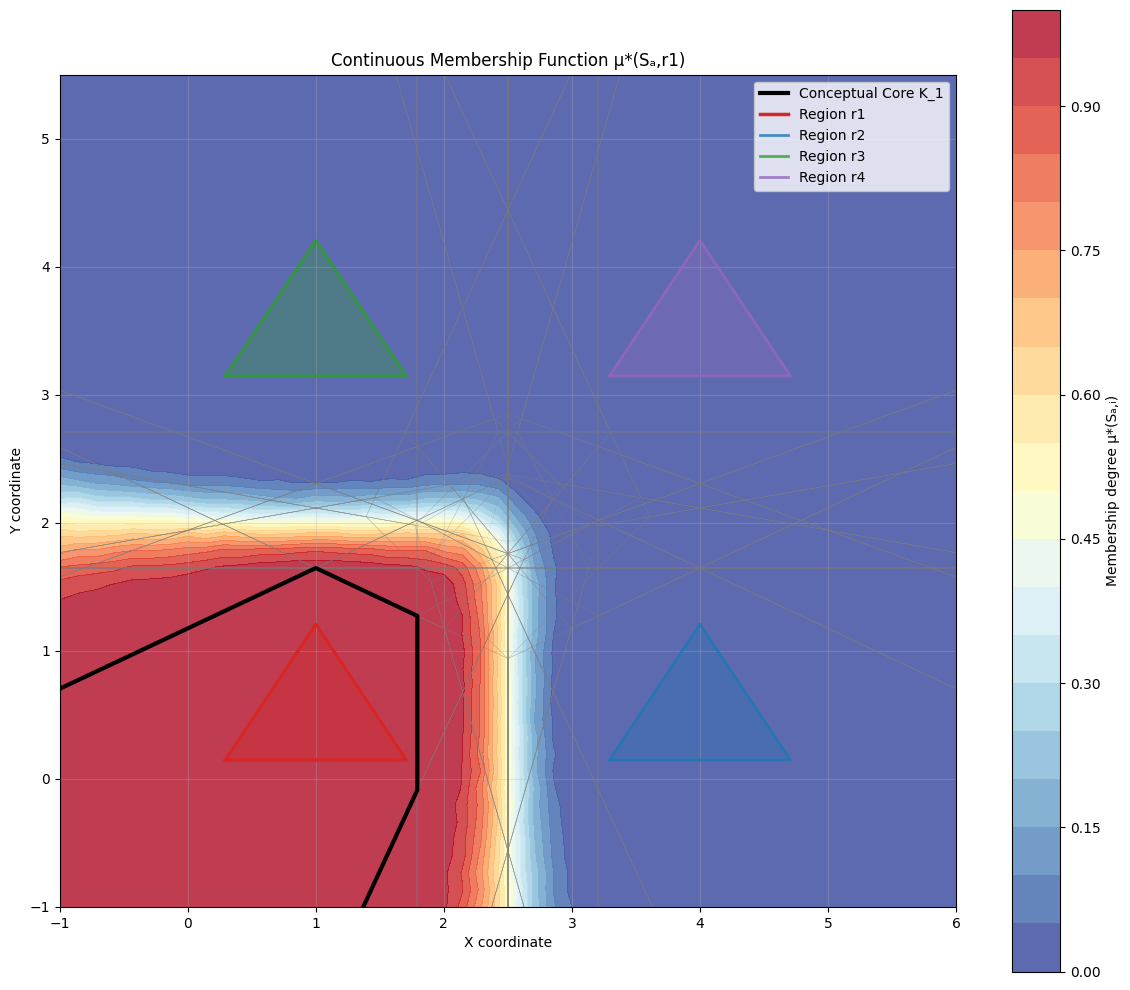


Membership Statistics for r1:
Max membership value: 1.000
Min membership value: 0.000
Mean membership value: 0.231


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
from shapely.geometry import Polygon, Point, LineString
from shapely.ops import unary_union
import itertools
from matplotlib.patches import Polygon as MPLPolygon
from matplotlib.collections import LineCollection
import warnings
warnings.filterwarnings('ignore')

# Step 1: Environment Setup and Data Definition

# Define the 12 vertices for the 4 triangular prototypical regions
vertices = {
    'r1': [(0.29289322, 0.14644661), (1.70710678, 0.14644661), (1.0, 1.20710678)],
    'r2': [(3.29289322, 0.14644661), (4.70710678, 0.14644661), (4.0, 1.20710678)],
    'r3': [(0.29289322, 3.14644661), (1.70710678, 3.14644661), (1.0, 4.20710678)],
    'r4': [(3.29289322, 3.14644661), (4.70710678, 3.14644661), (4.0, 4.20710678)],
}

# Create Shapely Polygon objects for each prototypical region
prototypical_regions = {
    name: Polygon(verts) for name, verts in vertices.items()
}

# Select target region (e.g., r1)
target_region = 'r1'
target_index = 0  # Index for r1

# Step 2: Discrete Framework Analysis

def generate_discrete_configurations():
    """Generate all 81 discrete configurations from vertex combinations."""
    configurations = []
    for combo in itertools.product(*[vertices[f'r{i+1}'] for i in range(4)]):
        configurations.append(combo)
    return configurations

def compute_voronoi_edges(points, bbox_size=10):
    """Compute Voronoi diagram and return edges clipped to bbox."""
    # Add buffer points far outside to bound the diagram
    buffer_points = [
        (-bbox_size, -bbox_size), (bbox_size, -bbox_size),
        (bbox_size, bbox_size), (-bbox_size, bbox_size)
    ]
    extended_points = list(points) + buffer_points

    vor = Voronoi(extended_points)
    edges = []

    for simplex in vor.ridge_vertices:
        if -1 not in simplex:
            p1 = vor.vertices[simplex[0]]
            p2 = vor.vertices[simplex[1]]
            edges.append((p1, p2))

    return edges

# Generate all discrete configurations
discrete_configs = generate_discrete_configurations()
print(f"Generated {len(discrete_configs)} discrete configurations")

# Compute all Voronoi edges
all_voronoi_edges = []
for config in discrete_configs:
    edges = compute_voronoi_edges(config)
    all_voronoi_edges.extend(edges)

# Step 3: Calculate the Conceptual Core

def get_voronoi_cell(vor, point_idx, bbox):
    """Extract the Voronoi cell for a given point as a Polygon."""
    region_idx = vor.point_region[point_idx]
    region = vor.regions[region_idx]

    if -1 in region or len(region) == 0:
        return None

    vertices = [vor.vertices[i] for i in region]

    # Check if vertices form a valid polygon
    if len(vertices) < 3:
        return None

    try:
        cell = Polygon(vertices)
        # Clip to bounding box
        clipped = cell.intersection(bbox)
        return clipped if clipped.is_valid else None
    except:
        return None

def compute_conceptual_core(configs, target_idx, bbox_size=10):
    """Compute the intersection of all relevant Voronoi cells."""
    bbox = Polygon([
        (-bbox_size, -bbox_size), (bbox_size, -bbox_size),
        (bbox_size, bbox_size), (-bbox_size, bbox_size)
    ])

    relevant_cells = []

    for config in configs:
        # Add buffer points
        buffer_points = [
            (-bbox_size*2, -bbox_size*2), (bbox_size*2, -bbox_size*2),
            (bbox_size*2, bbox_size*2), (-bbox_size*2, bbox_size*2)
        ]
        extended_points = list(config) + buffer_points

        vor = Voronoi(extended_points)
        cell = get_voronoi_cell(vor, target_idx, bbox)

        if cell and cell.is_valid and not cell.is_empty:
            relevant_cells.append(cell)

    # Compute intersection
    if relevant_cells:
        core = relevant_cells[0]
        for cell in relevant_cells[1:]:
            core = core.intersection(cell)
            if core.is_empty:
                break
        return core if core.is_valid and not core.is_empty else None

    return None

# Calculate conceptual core
conceptual_core = compute_conceptual_core(discrete_configs, target_index)
print(f"Conceptual core computed: {conceptual_core is not None}")

# Step 4: Monte Carlo Simulation for Continuous Membership Function

def sample_point_in_triangle(triangle_vertices):
    """Sample a random point inside a triangle using barycentric coordinates."""
    v1, v2, v3 = np.array(triangle_vertices)

    # Generate random barycentric coordinates
    r1, r2 = np.random.random(2)
    if r1 + r2 > 1:
        r1 = 1 - r1
        r2 = 1 - r2
    r3 = 1 - r1 - r2

    # Convert to Cartesian coordinates
    point = r1 * v1 + r2 * v2 + r3 * v3
    return tuple(point)

def compute_membership_monte_carlo(point, n_samples=1000):
    """Compute μ*(Sₐ,ᵢ) for a given point using Monte Carlo simulation."""
    favorable = 0

    for _ in range(n_samples):
        # Generate random configuration
        config = []
        for i in range(4):
            triangle_verts = vertices[f'r{i+1}']
            random_point = sample_point_in_triangle(triangle_verts)
            config.append(random_point)

        # Check if target prototype is closest to the point
        distances = [np.linalg.norm(np.array(point) - np.array(p)) for p in config]
        if np.argmin(distances) == target_index:
            favorable += 1

    return favorable / n_samples

# Define analysis grid
grid_resolution = 50
x_range = np.linspace(-1, 6, grid_resolution)
y_range = np.linspace(-1, 5.5, grid_resolution)
X, Y = np.meshgrid(x_range, y_range)

# Compute membership values
print("Computing membership values via Monte Carlo...")
membership_values = np.zeros_like(X)
n_samples = 2000  # Adjust for speed/accuracy tradeoff

for i in range(grid_resolution):
    for j in range(grid_resolution):
        point = (X[i, j], Y[i, j])
        membership_values[i, j] = compute_membership_monte_carlo(point, n_samples)

    if i % 10 == 0:
        print(f"Progress: {i}/{grid_resolution}")

# Step 5: Final Visualization

fig, ax = plt.subplots(figsize=(12, 10))

# 1. Heatmap background
im = ax.contourf(X, Y, membership_values, levels=20, cmap='RdYlBu_r', alpha=0.8)
cbar = plt.colorbar(im, ax=ax, label='Membership degree μ*(Sₐ,ᵢ)')

# 2. Discrete grid overlay (Voronoi edges)
edge_collection = []
for edge in all_voronoi_edges:
    if edge[0] is not None and edge[1] is not None:
        edge_collection.append([edge[0], edge[1]])

if edge_collection:
    lc = LineCollection(edge_collection, colors='gray', linewidths=0.3, alpha=0.3)
    ax.add_collection(lc)

# 3. Conceptual Core highlight
if conceptual_core and not conceptual_core.is_empty:
    if conceptual_core.geom_type == 'Polygon':
        x, y = conceptual_core.exterior.xy
        ax.plot(x, y, 'k-', linewidth=3, label=f'Conceptual Core K_{target_region[1]}')
    elif conceptual_core.geom_type == 'MultiPolygon':
        for poly in conceptual_core.geoms:
            x, y = poly.exterior.xy
            ax.plot(x, y, 'k-', linewidth=3)

# 4. Draw and fill prototypical regions (triangles)
# Define a distinct color for each of the 4 regions
region_colors = {'r1': '#d62728', 'r2': '#1f77b4', 'r3': '#2ca02c', 'r4': '#9467bd'} # Red, Blue, Green, Purple
for name, region in prototypical_regions.items():
    x, y = region.exterior.xy
    color = region_colors[name]

    is_target = (name == target_region)
    outline_alpha = 1.0 if is_target else 0.8
    linewidth = 2.5 if is_target else 2.0
    # Use a low alpha for the fill so the heatmap underneath is visible
    fill_alpha = 0.3

    # Draw the outline, labeling each region for the legend
    ax.plot(x, y, color=color, linewidth=linewidth, alpha=outline_alpha, label=f'Region {name}')

    # Fill the region with the same color but lower alpha
    ax.fill(x, y, color=color, alpha=fill_alpha)


# Formatting
ax.set_xlim(-1, 6)
ax.set_ylim(-1, 5.5)
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')
ax.set_title(f'Continuous Membership Function μ*(Sₐ,{target_region})')
ax.legend(loc='upper right')
ax.grid(True, alpha=0.3)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()

# Additional analysis: Show membership statistics
print(f"\nMembership Statistics for {target_region}:")
print(f"Max membership value: {np.max(membership_values):.3f}")
print(f"Min membership value: {np.min(membership_values):.3f}")
print(f"Mean membership value: {np.mean(membership_values):.3f}")